In [25]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import trange

In [26]:
PATH = os.path.abspath(os.getcwd())
PATH

'/home/ademattos/carNocar'

In [27]:
file = open('splits/Combined/CNRParkAB_Ext_train.txt')
for line in file:
    print(line)
    break

SUNNY/2016-01-13/camera9/S_2016-01-13_10.52_C09_253.jpg 1



In [43]:
class CNRParkCombinedDataset(Dataset):
    def __init__(self, root_path, transform):
        self.root_path = root_path
        self.images = [line.split()[0] for line in open(root_path)]
        self.labels = [int(line.split()[1][0]) for line in open(root_path)]
        self.transform = transform
    
    def __len__(self):
        return len(open(self.root_path).readlines())
    
    def __getitem__(self, index):
        img_loc = os.path.join(PATH+'/PATCHES',self.images[index])
        img = Image.open(img_loc).convert("RGB")
        label = self.labels[index]
        label = torch.tensor(label).to('cuda')
        
        if self.transform is not None:
            img = self.transform(img).to('cuda')
#             img = img.reshape((3,150,150))
    
        return img,label
        

In [44]:
tfms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((150,150)),
    torchvision.transforms.ToTensor()])
dset = CNRParkCombinedDataset(PATH+'/splits/Combined/CNRParkAB_Ext_train.txt', transform=tfms)

In [45]:
img,label = dset.__getitem__(3)
img.shape, label

(torch.Size([3, 150, 150]), tensor(1, device='cuda:0'))

In [46]:
train_loader = DataLoader(dset,batch_size=64,shuffle=True)
len(dset)

107077

In [47]:
train_iter = iter(train_loader)
images,labels = train_iter.next()
images.size(),labels.size()

(torch.Size([64, 3, 150, 150]), torch.Size([64]))

In [48]:
grid = torchvision.utils.make_grid(images)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
plt.title(labels)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [49]:

#model
class ApdNet(torch.nn.Module):
    def __init__(self):
        super(ApdNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(87616, 1000)
        self.fc2 = nn.Linear(1000, 2)
    def forward(self,x):
        #Max pooling over (2,2) window
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
    def num_flat_features(self,x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Epoch [2/2], Step [1674,1674], Loss: 0.0454, Accuracy: 100.00%: 100%|██████████| 2/2 [04:36<00:00, 138.26s/it]


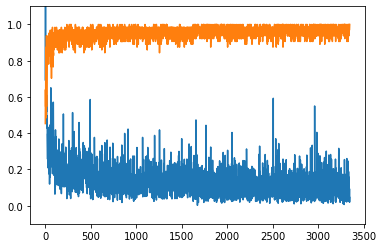

In [50]:

model = ApdNet()
model.cuda()

loss_list, acc_list = [],[]
loss_func = nn.CrossEntropyLoss().to('cuda')
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 2
total_step = len(train_loader)
for epoch in (t := trange(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = loss_func(outputs,labels)
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total = labels.size(0)
        _, predicted = torch.max(outputs.data,1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct/total)
        
        t.set_description('Epoch [{}/{}], Step [{},{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch+1, num_epochs, i+1, total_step, loss.item(),
                       (correct/total)*100))
    
plt.ylim(-0.1,1.1)
plt.plot(loss_list)
plt.plot(acc_list)

In [52]:
model.eval()
img = Image.open(PATH+'/test_images/no_car.png').convert("RGB")
img = torchvision.transforms.functional.resize(img, (150,150))
img = torchvision.transforms.functional.to_tensor(img)
img = img.unsqueeze(0).to('cuda')
print(img.shape)
with torch.no_grad():
    output = model(img)
output

torch.Size([1, 3, 150, 150])


tensor([[-0.1008, -0.3082]], device='cuda:0')

In [53]:
torch.save(model.state_dict(), 'cnr_car_combined_model.pt')